In [10]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
%matplotlib inline

from keras import backend as K
from keras.layers import Layer, Input, Conv2D, MaxPooling2D
import tensorflow as tf

In [3]:
#base_model test
import base_model
base = base_model.Base()
fmap = base.get_fmap()
base.get_config()

{'name': 'base',
 'trainable': True,
 'dtype': 'float32',
 'base': 'VGG16',
 'channels': 3,
 'input_shape': TensorShape([None, None, None, 3]),
 'fmap_shape': TensorShape([None, None, None, 512])}

In [4]:
#pooling test
import roi_pooling

#test pool.call after the rois are generated
pool = roi_pooling.RoIPooling(pool_size = 7, num_rois = 1)
pool.get_config()

{'name': 'ro_i_pooling',
 'trainable': True,
 'dtype': 'float32',
 'pool_size': 7,
 'num_rois': 1}

## Testing Region Proposals (generate.py)

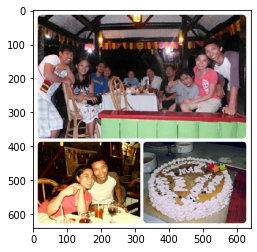

In [32]:
#rpn proposals
from rpn.generate import generate_anchor_boxes
img = cv2.imread("test_img/10245691204_98dce75b5a_o.jpg")
bbox = pd.read_csv("test_img/test_bbox.csv")
cls_labels = pd.read_csv("test_img/class_labels.csv")
plt.imshow(img[:,:,[2,1,0]])

In [33]:
bbox=bbox.drop(['Unnamed: 0'],axis=1)
bbox

,ImageID,Source,LabelName,Confidence,XMin,XMax,YMin,YMax,IsOccluded,IsTruncated,IsGroupOf,IsDepiction,IsInside
0,000002b66c9c498e,xclick,/m/01g317,1,0.012500,0.195312,0.148438,0.587500,0,1,0,0,0
1,000002b66c9c498e,xclick,/m/01g317,1,0.025000,0.276563,0.714063,0.948438,0,1,0,0,0
2,000002b66c9c498e,xclick,/m/01g317,1,0.151562,0.310937,0.198437,0.590625,1,0,0,0,0
3,000002b66c9c498e,xclick,/m/01g317,1,0.256250,0.429688,0.651563,0.925000,1,0,0,0,0
4,000002b66c9c498e,xclick,/m/01g317,1,0.257812,0.346875,0.235938,0.385938,1,0,0,0,0
5,000002b66c9c498e,xclick,/m/01g317,1,0.320312,0.368750,0.260938,0.328125,1,0,0,0,0
6,000002b66c9c498e,xclick,/m/01g317,1,0.412500,0.945312,0.120312,0.475000,1,0,1,0,0
7,000002b66c9c498e,xclick,/m/0284d,1,0.528125,0.923437,0.675000,0.964063,0,0,0,0,0
8,000002b66c9c498e,xclick,/m/04bcr3,1,0.064062,0.492188,0.889063,0.993750,0,0,0,0,0
9,000002b66c9c498e,xclick,/m/04bcr3,1,0.301562,0.990625,0.462500,0.595312,0,0,0,0,0


In [35]:
cls_labels = cls_labels.drop(['Unnamed: 0'],axis=1)
cls_labels

,Name,Class
0,/m/01g317,Person
1,/m/0284d,Dairy
2,/m/04bcr3,Table
3,/m/0fszt,Cake
4,/m/0hnyx,Pastry
